In [28]:
# Python library and module imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import math
import h5py
import torch

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)
    
# Import the custom plotting module
from plot_utils import plot_utils

# WatChMaL imports
from io_utils.data_handling_2 import WCH5Dataset

# PyTorch imports
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from collections import Counter 
from scipy import stats

In [2]:
label_dict = {0:["gamma", "red"], 1:["e", "blue"], 2:["mu", "green"]}

In [3]:
path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M.h5"
f = h5py.File(path, 'r')
f.keys()

<KeysViewHDF5 ['angles', 'energies', 'event_data', 'event_ids', 'labels', 'positions', 'root_files']>

In [4]:
label_dict = {0:["gamma", "red"], 1:["e", "blue"], 2:["mu", "green"]}

Read the dataset frim the disk

In [5]:
train_batch_size = 1024
dset=WCH5Dataset(path, 0.1, 0.1, reduced_dataset_size=300000)

# Initialize the dataloader
train_loader = DataLoader(dset, batch_size=train_batch_size, shuffle=False,
                          num_workers=4, sampler=SubsetRandomSampler(dset.train_indices))

# Read the tensors from the dataset and add to the list
event_charges = []
event_timings = []

labels = []
energies = []

for data in iter(train_loader):
    event_charges.append(data[0][:,:,:,:19].numpy())
    event_timings.append(data[0][:,:,:,19:].numpy())
    
    labels.append(data[1].numpy())
    energies.append(data[2].numpy())
    
print(len(event_charges), event_charges[0].shape, len(event_timings), event_timings[0].shape)
print(len(labels), labels[0].shape, len(energies), energies[0].shape)

235 (1024, 40, 40, 19) 235 (1024, 40, 40, 19)
235 (1024,) 235 (1024, 1)


In [6]:
event_charges = np.concatenate(event_charges, axis=0)
event_timings = np.concatenate(event_timings, axis=0)

labels = np.concatenate(labels, axis=0)
energies = np.concatenate(energies, axis=0)

print(event_charges.shape, event_timings.shape, labels.shape, energies.shape)

(240000, 40, 40, 19) (240000, 40, 40, 19) (240000,) (240000, 1)


Unnormalized charge-timing distribution

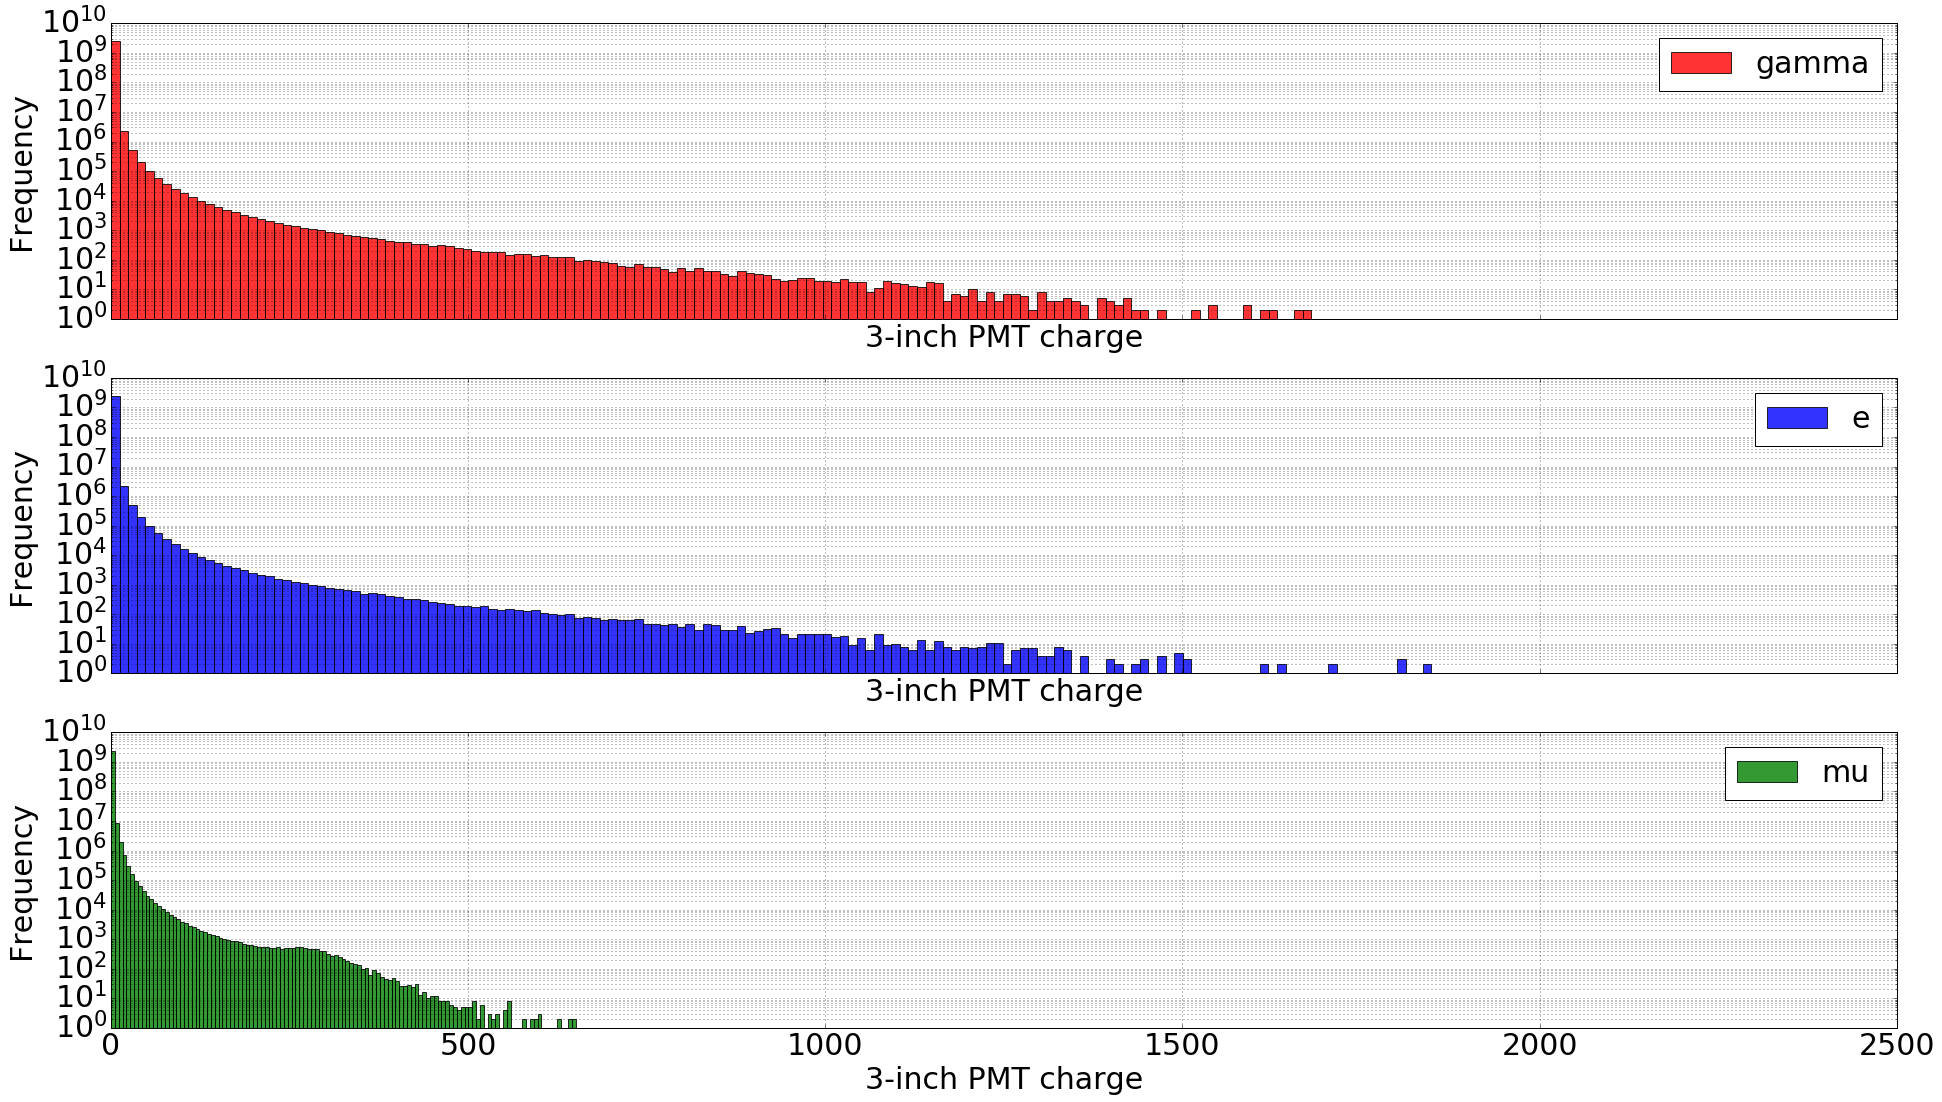

In [7]:
event_charge_dict = {}
for label in label_dict.keys():
    event_charge_dict[label] = event_charges[labels == label].reshape(-1)
    
fig, axes = plt.subplots(3, 1, figsize=(32,18), sharex=True)

for label in label_dict.keys():
    axes[label].hist(event_charge_dict[label], bins=200, density=False, label=label_dict[label][0], alpha=0.8,
                     color=label_dict[label][1])
    axes[label].legend(prop={"size":30})
    axes[label].set_xlabel("3-inch PMT charge", fontsize=30)
    axes[label].set_ylabel("Frequency", fontsize=30)
    axes[label].tick_params(axis="both", labelsize=30)
    axes[label].grid(True, which="both", axis="both")
    axes[label].set_yscale("log")

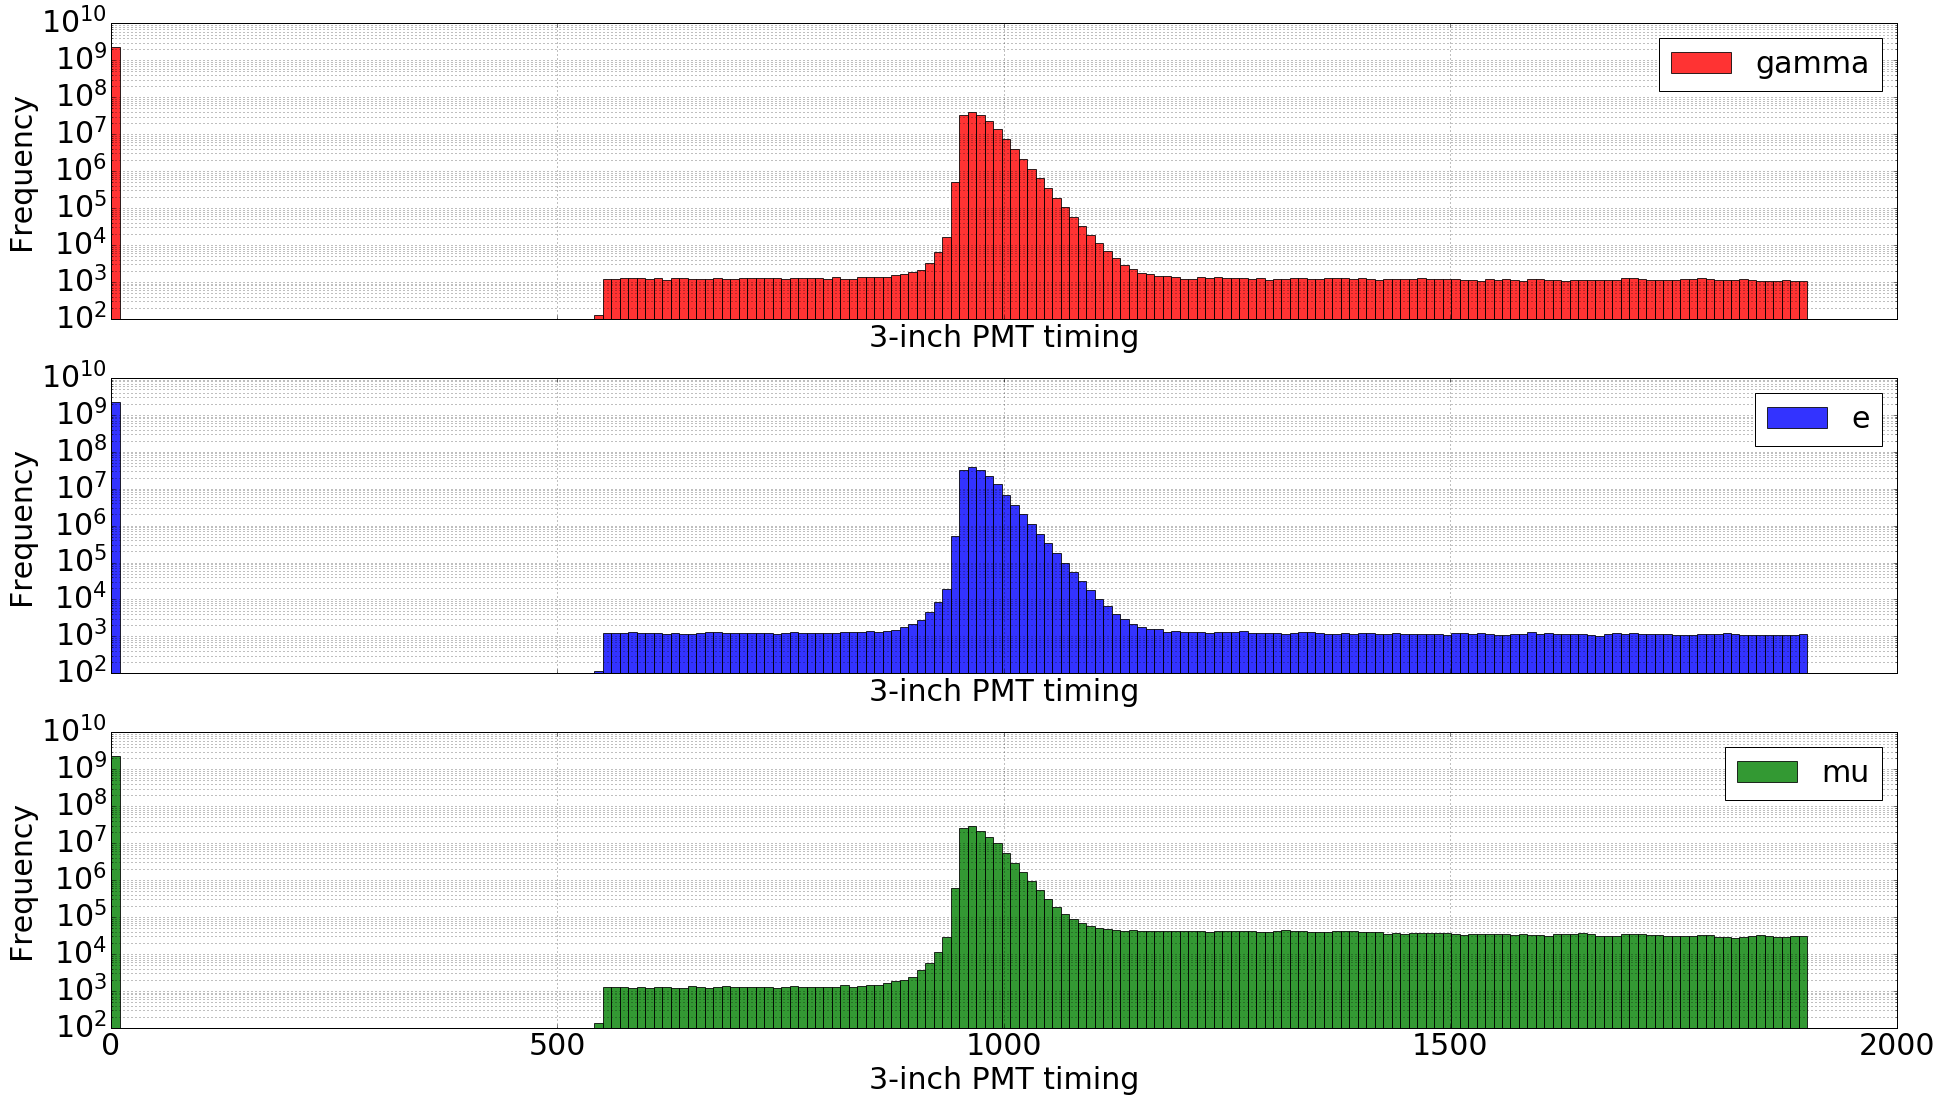

In [8]:
event_timing_dict = {}
for label in label_dict.keys():
    event_timing_dict[label] = event_timings[labels == label].reshape(-1)
    
fig, axes = plt.subplots(3, 1, figsize=(32,18), sharex=True)

for label in label_dict.keys():
    axes[label].hist(event_timing_dict[label], bins=200, density=False, label=label_dict[label][0], alpha=0.8,
                     color=label_dict[label][1])
    axes[label].legend(prop={"size":30})
    axes[label].set_xlabel("3-inch PMT timing", fontsize=30)
    axes[label].set_ylabel("Frequency", fontsize=30)
    axes[label].tick_params(axis="both", labelsize=30)
    axes[label].grid(True, which="both", axis="both")
    axes[label].set_yscale("log")

Reduce the number of events for doing normalization and statistical analysis

In [9]:
subset_event_charges = event_charges[:10000]
subset_event_timings = event_timings[:10000]

subset_labels = labels[:10000]
subset_energies = energies[:10000]

Simple statistical features of the raw data

In [10]:
print(np.mean(subset_event_charges.reshape(-1)))
print(np.mean(subset_event_timings.reshape(-1)))

0.1458153
57.592117


In [11]:
print(np.var(subset_event_charges.reshape(-1)))
print(np.var(subset_event_timings.reshape(-1)))

2.8314986
53164.723


In [12]:
print(np.std(subset_event_charges.reshape(-1)))
print(np.std(subset_event_timings.reshape(-1)))

1.6827058
230.57477


In [13]:
print(np.amin(subset_event_charges.reshape(-1)))
print(np.amin(subset_event_timings.reshape(-1)))

0.0
0.0


In [14]:
print(np.amax(subset_event_charges.reshape(-1)))
print(np.amax(subset_event_timings.reshape(-1)))

2400.8643
1900.0


Simple statistical features of the raw data (without the zero hits)

In [15]:
print(subset_event_charges.shape, subset_event_timings.shape)

(10000, 40, 40, 19) (10000, 40, 40, 19)


In [16]:
reshaped_subset_event_charges = subset_event_charges.reshape(-1)
reshaped_subset_event_timings = subset_event_timings.reshape(-1)

In [17]:
print(reshaped_subset_event_charges.shape, reshaped_subset_event_timings.shape)

(304000000,) (304000000,)


In [18]:
nonzero_subset_event_charges = reshaped_subset_event_charges[reshaped_subset_event_charges > 0.]
nonzero_subset_event_timings = reshaped_subset_event_timings[reshaped_subset_event_timings > 0.]

In [19]:
print(nonzero_subset_event_charges.shape, nonzero_subset_event_timings.shape)

(17901317,) (17901317,)


In [20]:
print(np.mean(nonzero_subset_event_charges.reshape(-1)))
print(np.mean(nonzero_subset_event_timings.reshape(-1)))

2.4762366
978.0302


In [21]:
print(np.var(nonzero_subset_event_charges.reshape(-1)))
print(np.var(nonzero_subset_event_timings.reshape(-1)))

42.313618
2625.6628


In [22]:
print(np.std(nonzero_subset_event_charges.reshape(-1)))
print(np.std(nonzero_subset_event_timings.reshape(-1)))

6.504892
51.241222


In [23]:
print(np.amin(nonzero_subset_event_charges.reshape(-1)))
print(np.amin(nonzero_subset_event_timings.reshape(-1)))

6.5954728e-06
550.0


In [24]:
print(np.amax(nonzero_subset_event_charges.reshape(-1)))
print(np.amax(nonzero_subset_event_timings.reshape(-1)))

2400.8643
1900.0


Apply simple feature scaling techniques (without the zero hits)

In [55]:
new_reshaped_subset_event_charges = subset_event_charges.reshape(subset_event_charges.shape[0], -1)
new_reshaped_subset_event_timings = subset_event_timings.reshape(subset_event_timings.shape[0], -1)

1. Min-max normalization

In [56]:
from sklearn.preprocessing import MinMaxScaler

In [57]:
min_max_scaler = MinMaxScaler(feature_range=(-1,1))

min_max_scaler.fit(new_reshaped_subset_event_charges)
min_max_scaled_charge = min_max_scaler.transform(new_reshaped_subset_event_charges)

min_max_scaler.fit(new_reshaped_subset_event_timings)
min_max_scaled_timings = min_max_scaler.transform(new_reshaped_subset_event_timings)

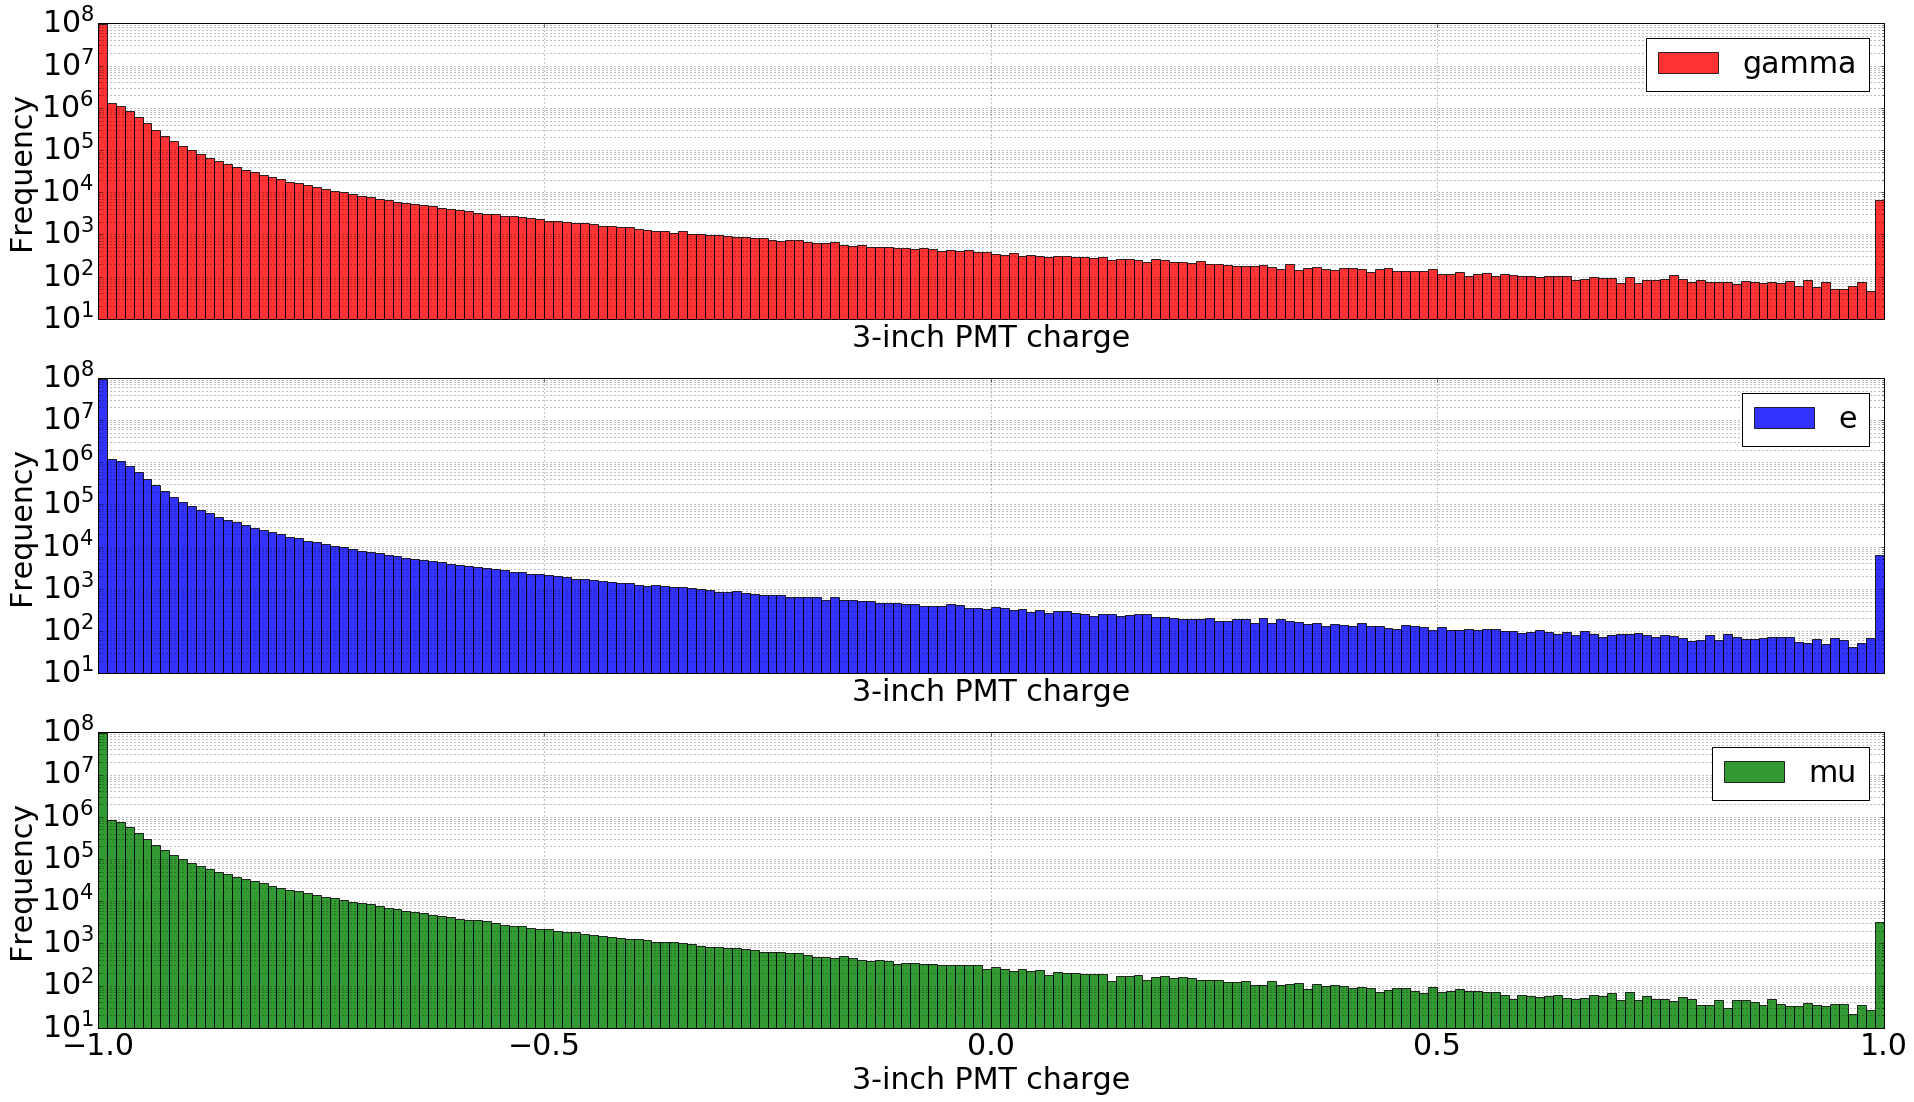

In [58]:
event_charge_dict = {}
for label in label_dict.keys():
    event_charge_dict[label] = min_max_scaled_charge[subset_labels == label].reshape(-1)
    
fig, axes = plt.subplots(3, 1, figsize=(32,18), sharex=True)

for label in label_dict.keys():
    axes[label].hist(event_charge_dict[label], bins=200, density=False, label=label_dict[label][0], alpha=0.8,
                     color=label_dict[label][1])
    axes[label].legend(prop={"size":30})
    axes[label].set_xlabel("3-inch PMT charge", fontsize=30)
    axes[label].set_ylabel("Frequency", fontsize=30)
    axes[label].tick_params(axis="both", labelsize=30)
    axes[label].grid(True, which="both", axis="both")
    axes[label].set_yscale("log")

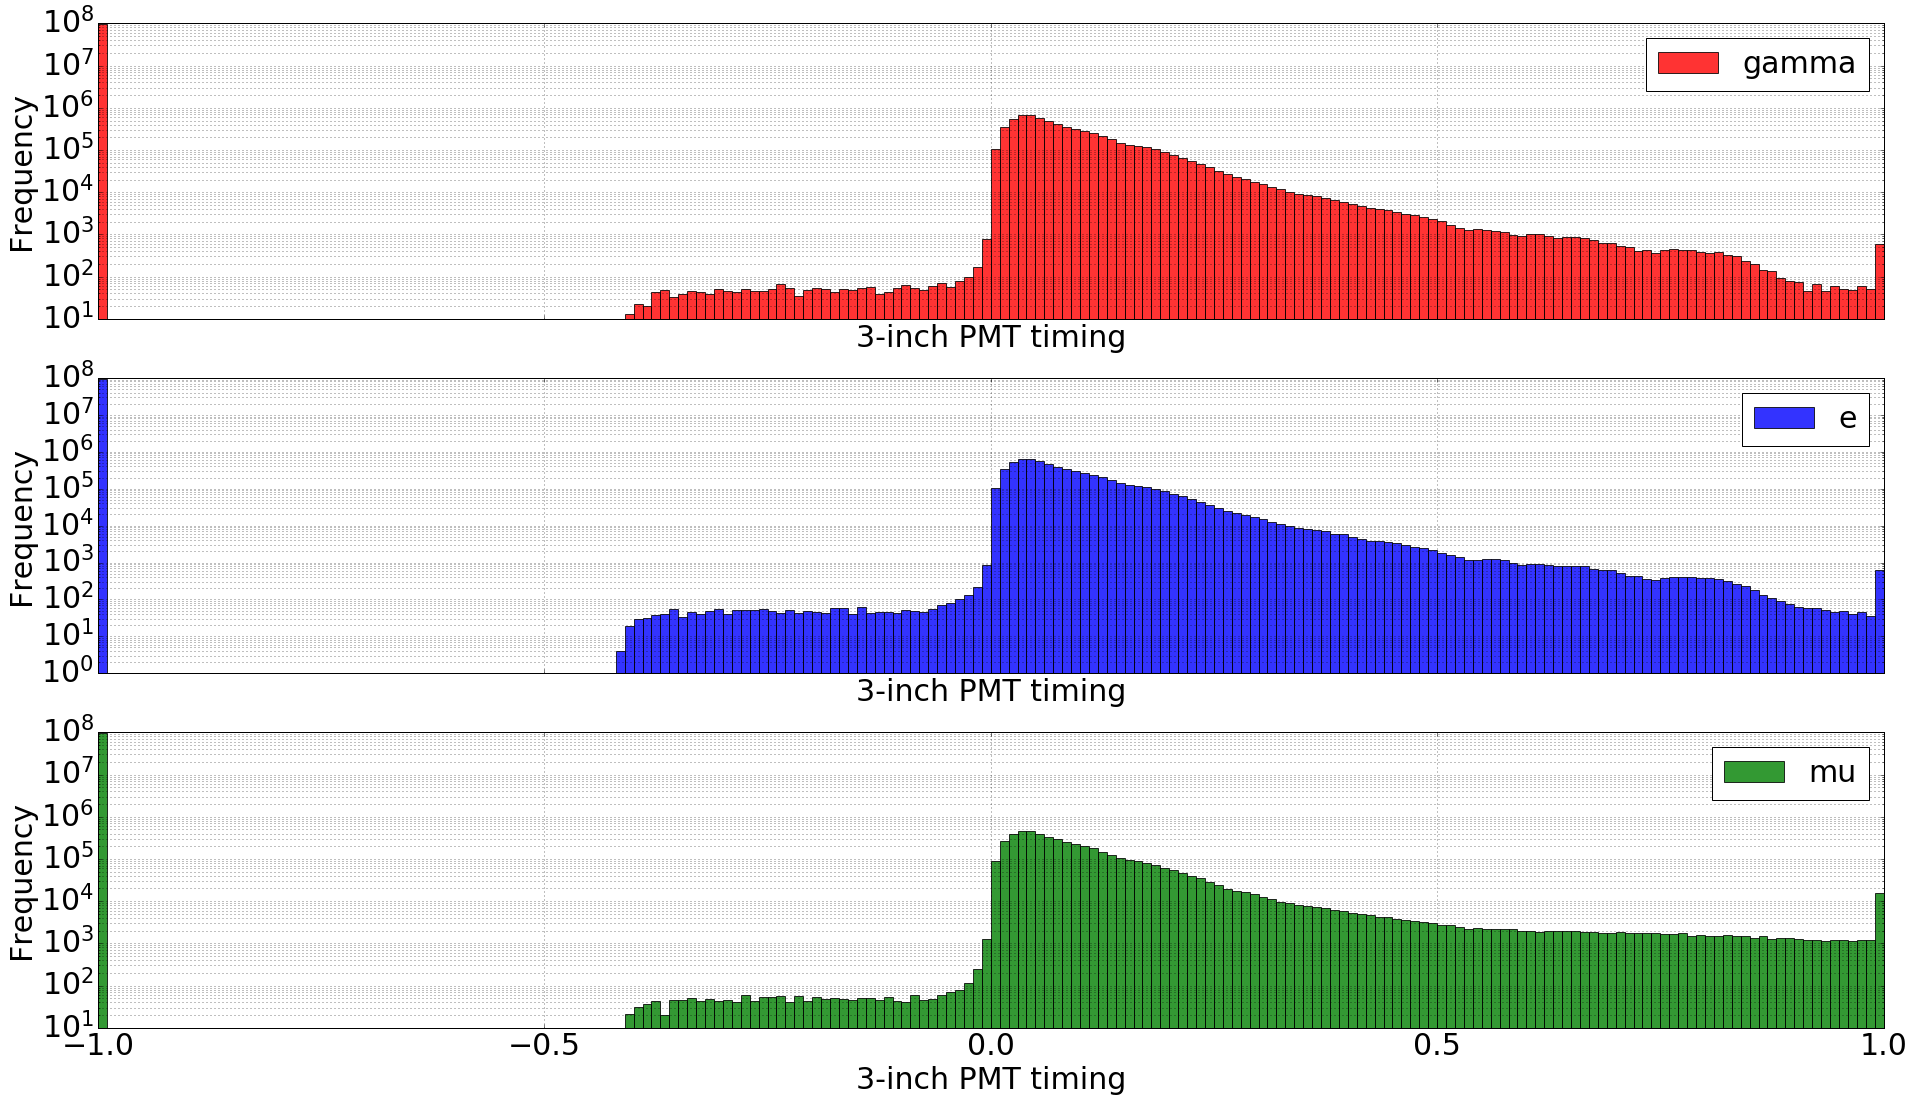

In [59]:
event_timing_dict = {}
for label in label_dict.keys():
    event_timing_dict[label] = min_max_scaled_timings[subset_labels == label].reshape(-1)
    
fig, axes = plt.subplots(3, 1, figsize=(32,18), sharex=True)

for label in label_dict.keys():
    axes[label].hist(event_timing_dict[label], bins=200, density=False, label=label_dict[label][0], alpha=0.8,
                     color=label_dict[label][1])
    axes[label].legend(prop={"size":30})
    axes[label].set_xlabel("3-inch PMT timing", fontsize=30)
    axes[label].set_ylabel("Frequency", fontsize=30)
    axes[label].tick_params(axis="both", labelsize=30)
    axes[label].grid(True, which="both", axis="both")
    axes[label].set_yscale("log")

2. Mean normalization

In [60]:
from sklearn.preprocessing import StandardScaler

In [61]:
std_scaler = StandardScaler()

std_scaler.fit(new_reshaped_subset_event_charges)
std_scaled_charge = std_scaler.transform(new_reshaped_subset_event_charges)

std_scaler.fit(new_reshaped_subset_event_timings)
std_scaled_timings = std_scaler.transform(new_reshaped_subset_event_timings)

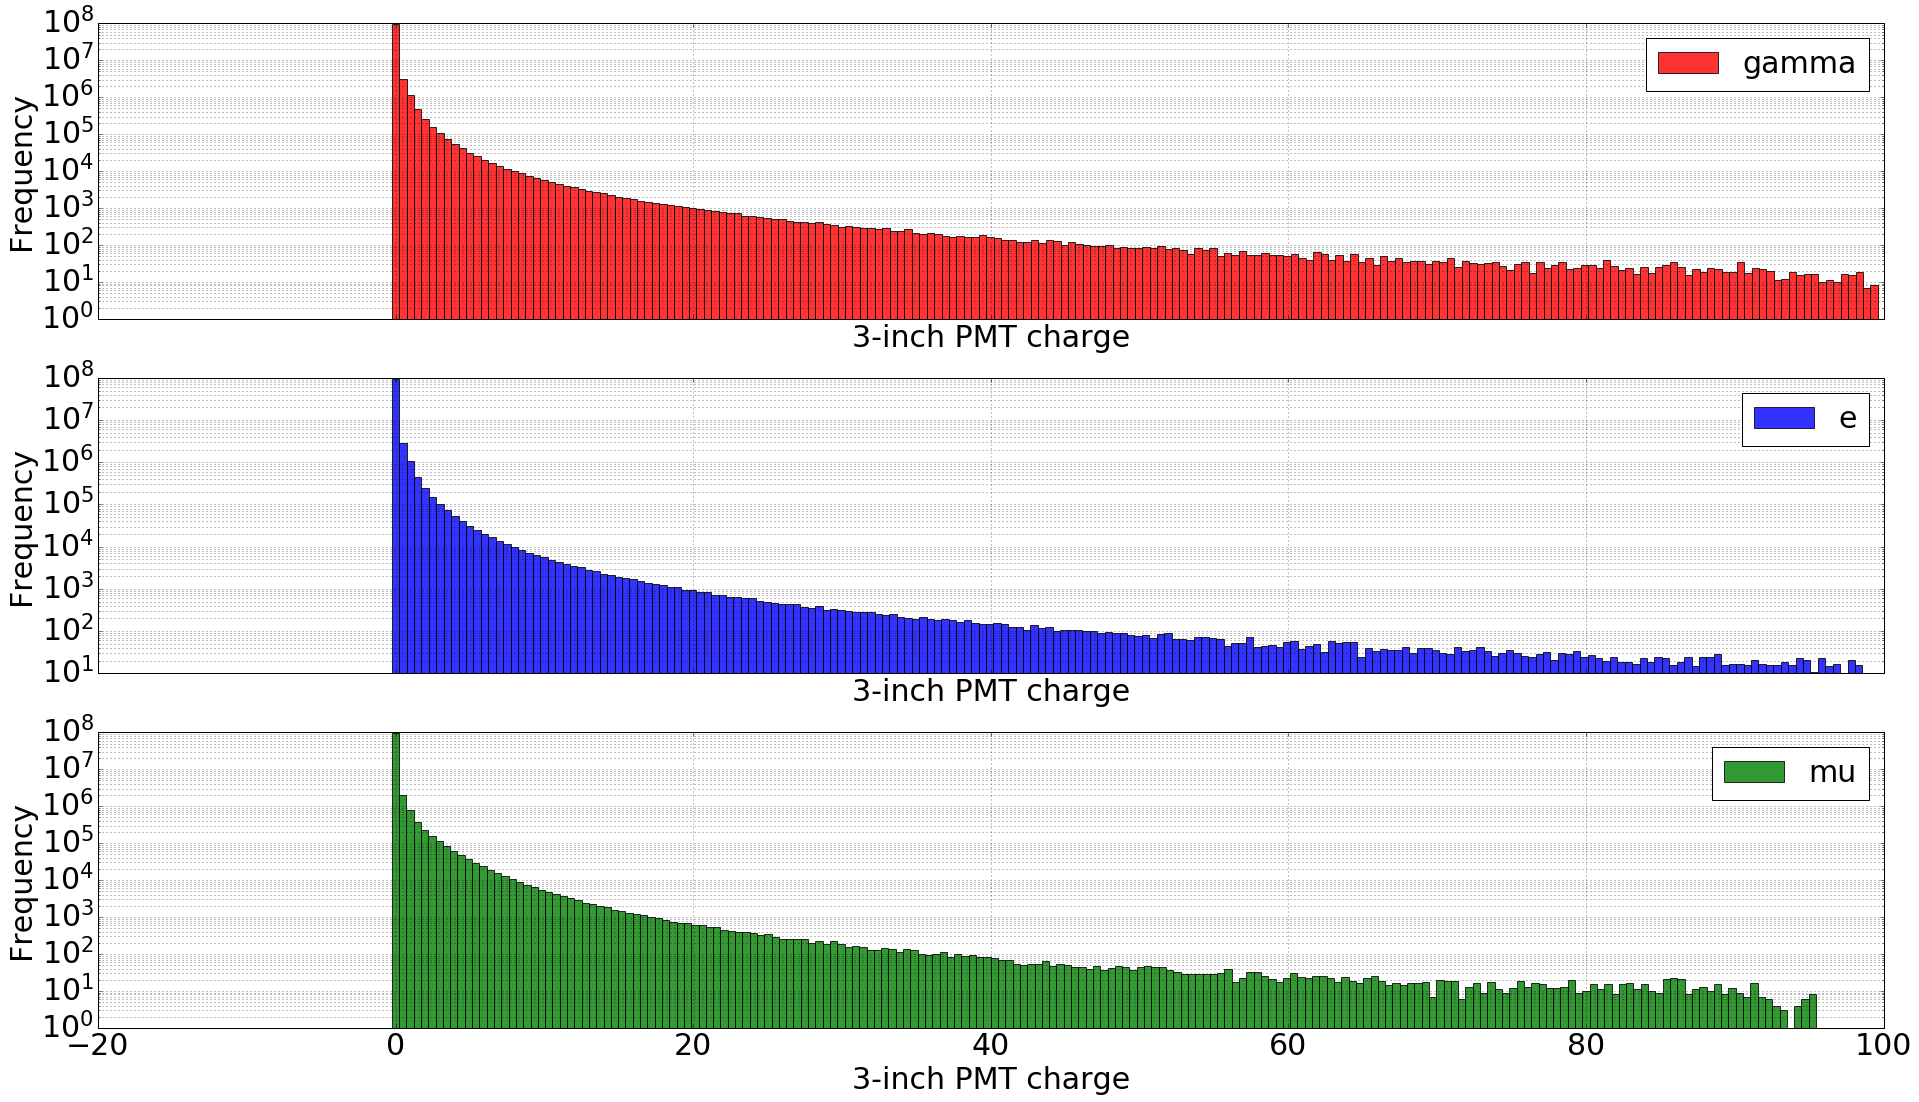

In [62]:
event_charge_dict = {}
for label in label_dict.keys():
    event_charge_dict[label] = std_scaled_charge[subset_labels == label].reshape(-1)
    
fig, axes = plt.subplots(3, 1, figsize=(32,18), sharex=True)

for label in label_dict.keys():
    axes[label].hist(event_charge_dict[label], bins=200, density=False, label=label_dict[label][0], alpha=0.8,
                     color=label_dict[label][1])
    axes[label].legend(prop={"size":30})
    axes[label].set_xlabel("3-inch PMT charge", fontsize=30)
    axes[label].set_ylabel("Frequency", fontsize=30)
    axes[label].tick_params(axis="both", labelsize=30)
    axes[label].grid(True, which="both", axis="both")
    axes[label].set_yscale("log")

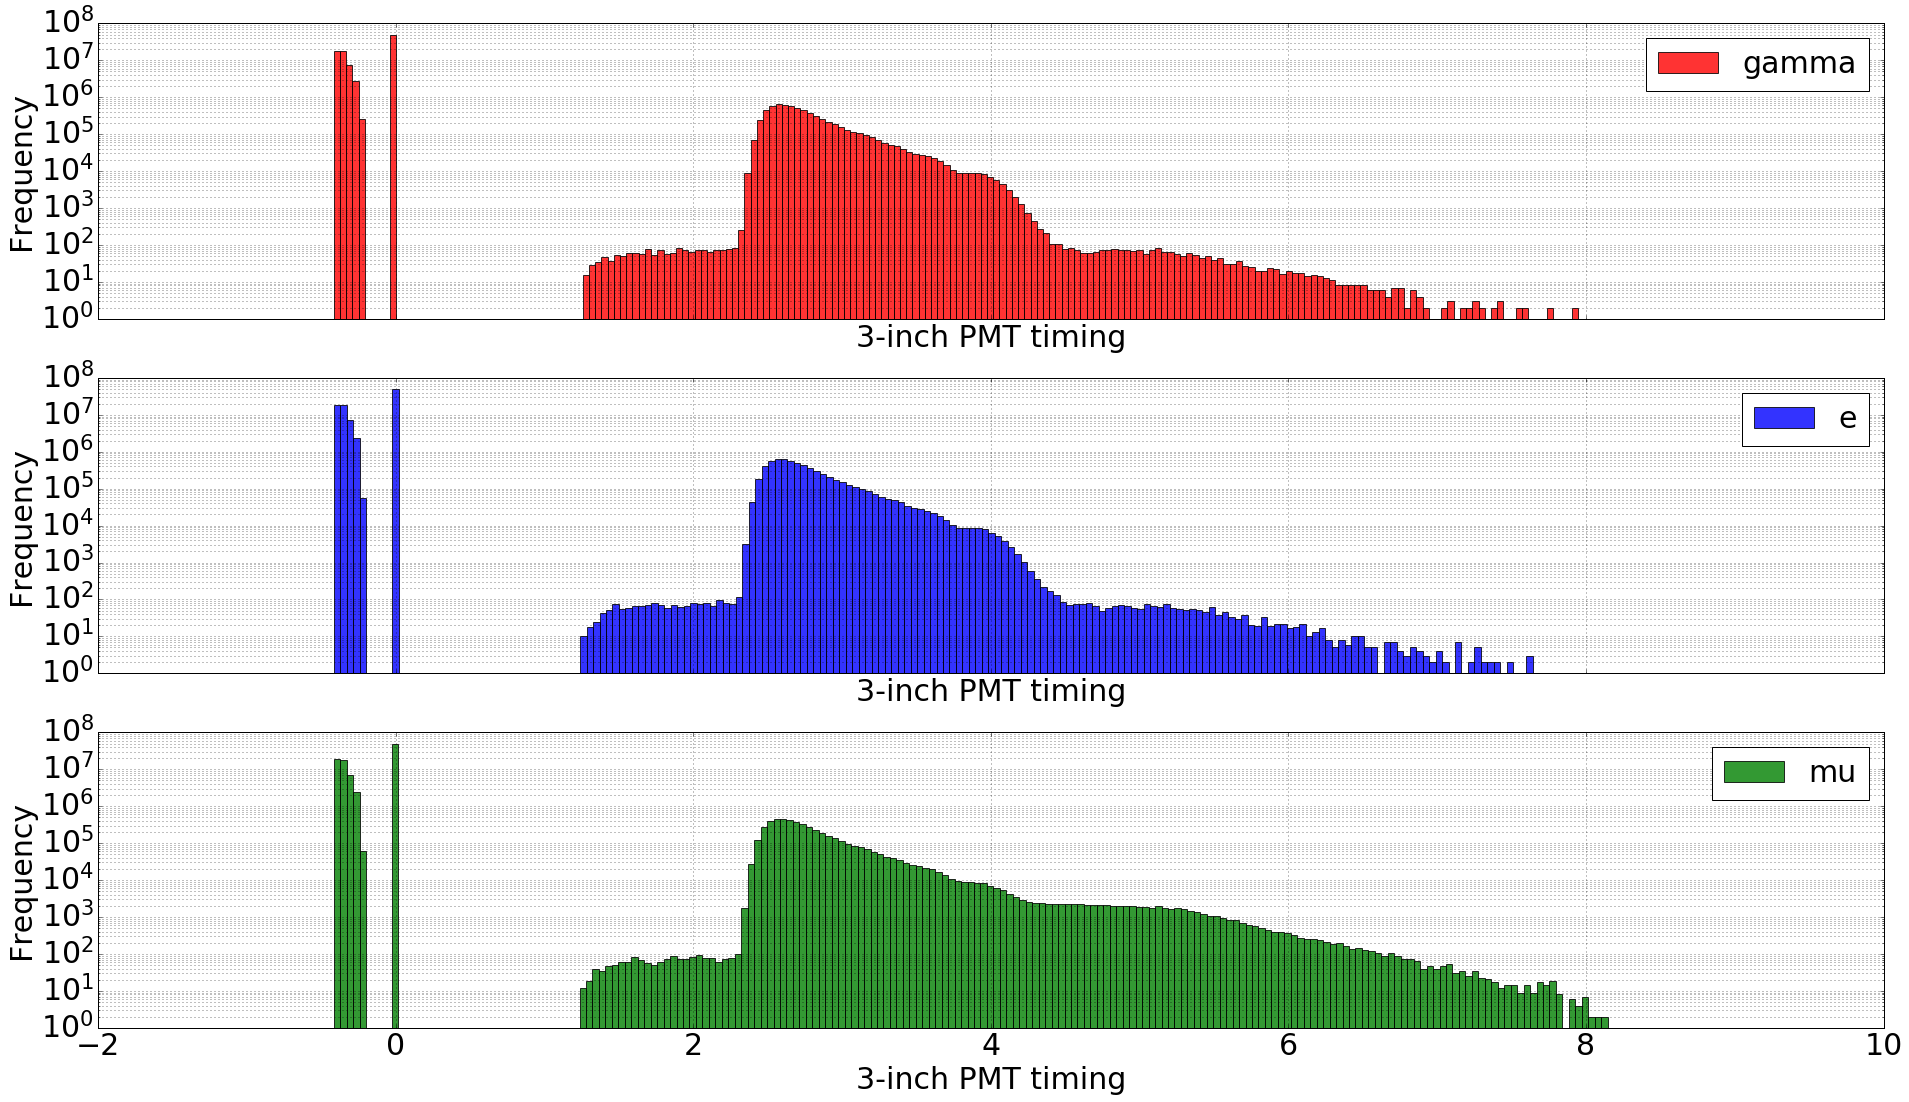

In [63]:
event_timing_dict = {}
for label in label_dict.keys():
    event_timing_dict[label] = std_scaled_timings[subset_labels == label].reshape(-1)
    
fig, axes = plt.subplots(3, 1, figsize=(32,18), sharex=True)

for label in label_dict.keys():
    axes[label].hist(event_timing_dict[label], bins=200, density=False, label=label_dict[label][0], alpha=0.8,
                     color=label_dict[label][1])
    axes[label].legend(prop={"size":30})
    axes[label].set_xlabel("3-inch PMT timing", fontsize=30)
    axes[label].set_ylabel("Frequency", fontsize=30)
    axes[label].tick_params(axis="both", labelsize=30)
    axes[label].grid(True, which="both", axis="both")
    axes[label].set_yscale("log")

In [64]:
print(std_scaled_charge.shape, std_scaled_timings.shape)

(10000, 30400) (10000, 30400)


In [65]:
print(std_scaled_charge[:,1].shape)

(10000,)


In [66]:
print(np.std(std_scaled_charge[:,1]), np.std(std_scaled_timings[:,1]))

0.0 0.0


1511 - Normalization contd.

Repeating the normalizations from before

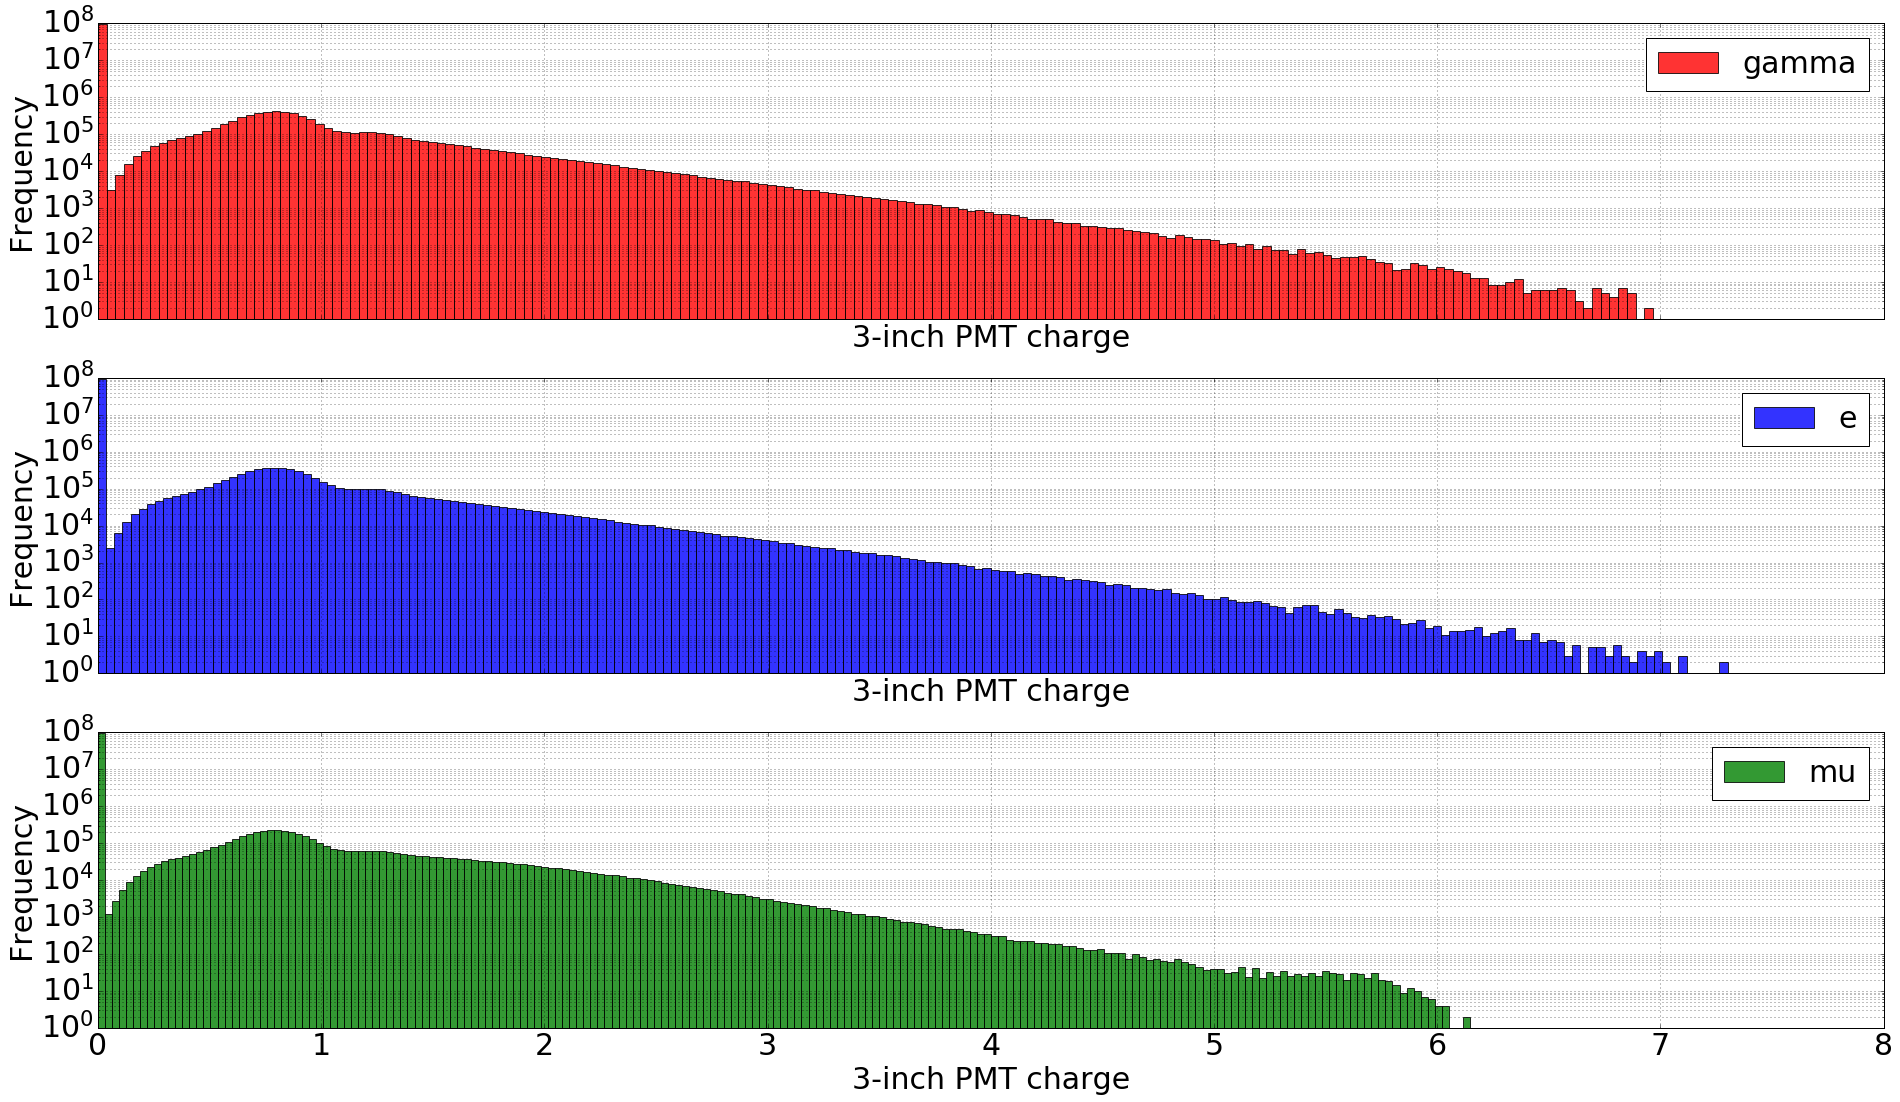

In [47]:
event_charge_dict = {}
for label in label_dict.keys():
    event_charge_dict[label] = np.log(subset_event_charges[subset_labels == label].reshape(-1) + 1.)
    
fig, axes = plt.subplots(3, 1, figsize=(32,18), sharex=True)

for label in label_dict.keys():
    axes[label].hist(event_charge_dict[label], bins=200, density=False, label=label_dict[label][0], alpha=0.8,
                     color=label_dict[label][1])
    axes[label].legend(prop={"size":30})
    axes[label].set_xlabel("3-inch PMT charge", fontsize=30)
    axes[label].set_ylabel("Frequency", fontsize=30)
    axes[label].tick_params(axis="both", labelsize=30)
    axes[label].grid(True, which="both", axis="both")
    axes[label].set_yscale("log")

In [32]:
timing_mode = stats.mode(subset_event_charges[subset_labels == 0].reshape(-1))
print(timing_mode[0])

[0.]


In [34]:
label_data = subset_event_timings[subset_labels == 0].reshape(-1)
timing_mode = stats.mode(label_data[label_data > 0.])[0]
print(timing_mode)

[958.5]


Finding peaks of the timing data

In [50]:
from scipy.signal import chirp, find_peaks, peak_widths

In [54]:
peaks, _ = find_peaks(label_data)
print(peaks)

results_half = peak_widths(label_data, peaks, rel_height=0.5)
print(len(results_half[0]), results_half[0][:100])

[     374     1084     1093 ... 99558152 99558849 99558895]
3107208 [1.         1.         1.97866287 1.98364582 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.99962573 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.9835343  1.         1.
 1.         1.         2.99976177 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.7652847  1.         1.         1.7581864  1.         1.
 1.         1.         1.         1.74700215 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.99943631 1.         1.         1.

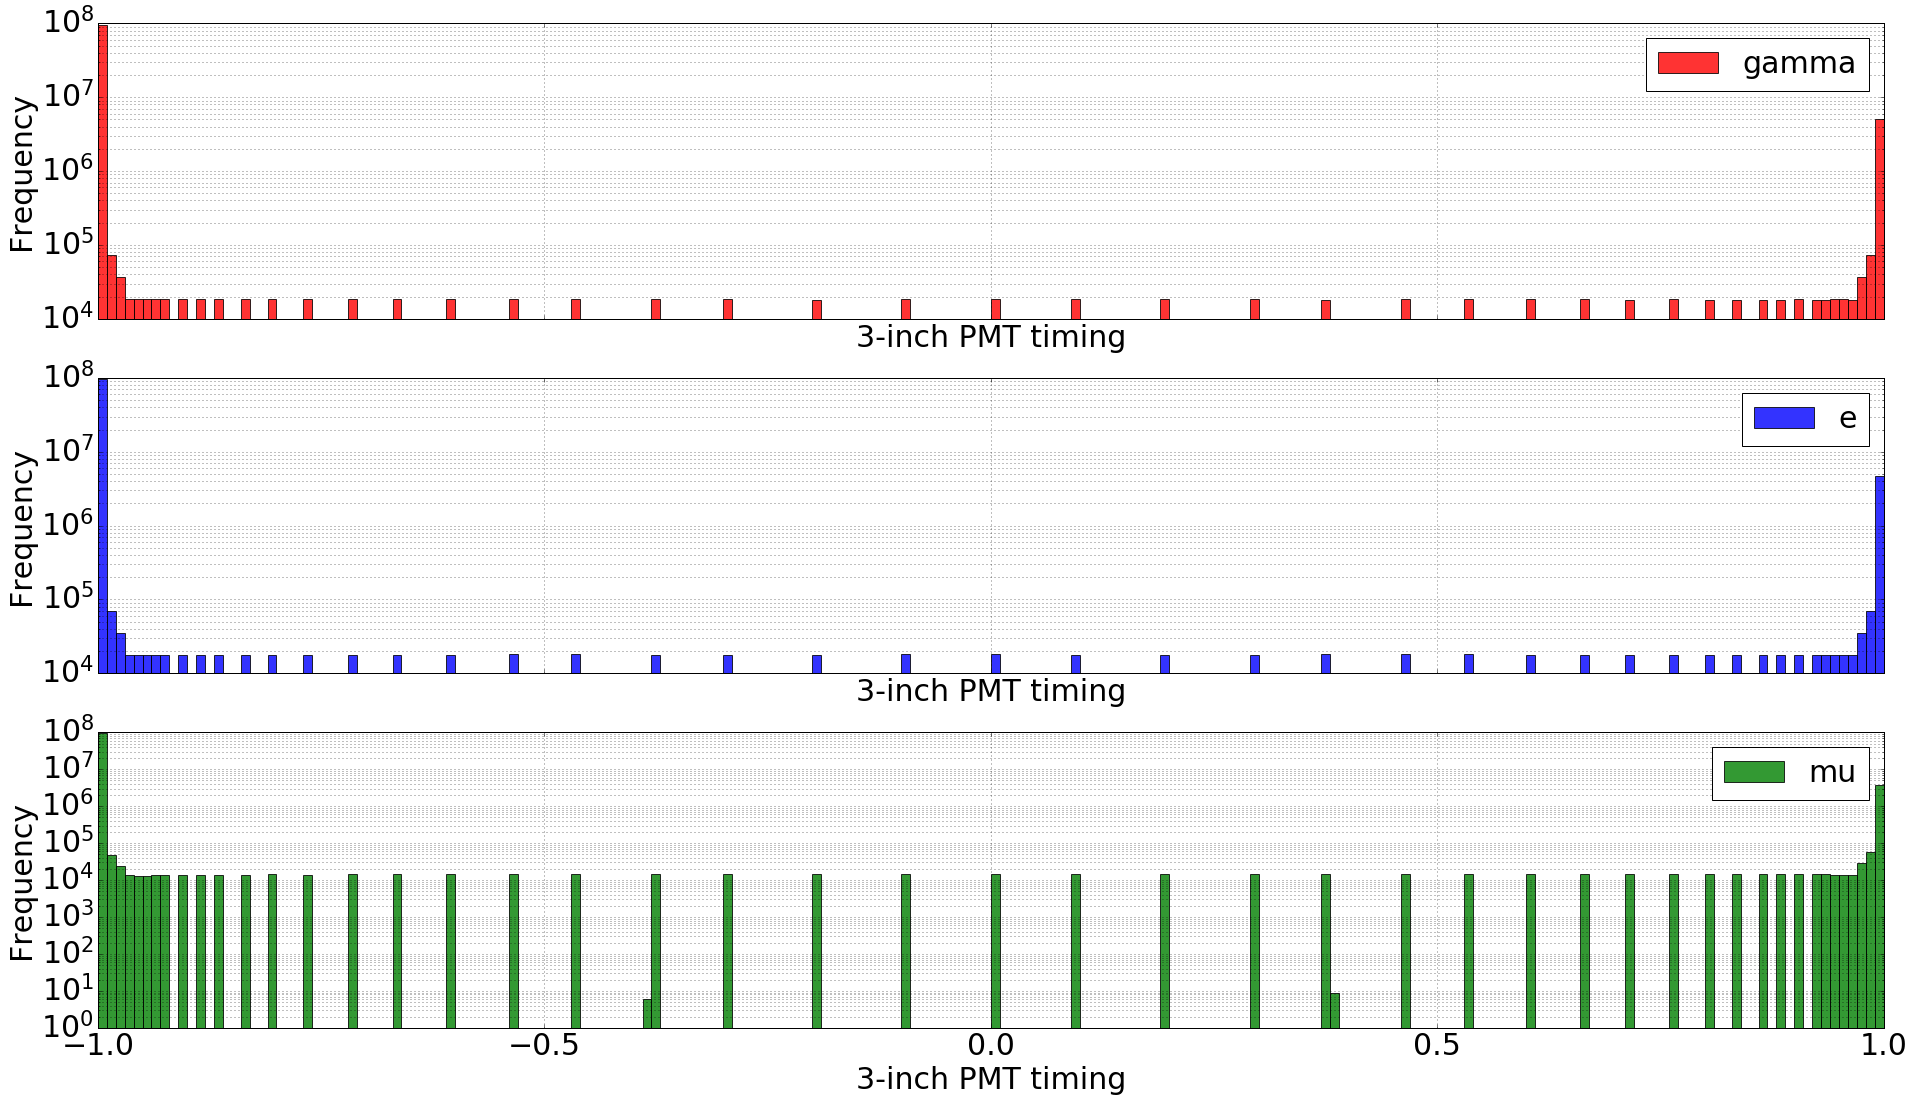

In [67]:
event_timings_dict = {}
for label in label_dict.keys():
    label_data = subset_event_timings[subset_labels == label].reshape(-1)
    timing_mode = stats.mode(label_data[label_data > 0.])[0]
    event_timings_dict[label] = np.tanh((label_data - timing_mode))
    
fig, axes = plt.subplots(3, 1, figsize=(32,18), sharex=True)

for label in label_dict.keys():
    axes[label].hist(event_timings_dict[label], bins=200, density=False, label=label_dict[label][0], alpha=0.8,
                     color=label_dict[label][1])
    axes[label].legend(prop={"size":30})
    axes[label].set_xlabel("3-inch PMT timing", fontsize=30)
    axes[label].set_ylabel("Frequency", fontsize=30)
    axes[label].tick_params(axis="both", labelsize=30)
    axes[label].grid(True, which="both", axis="both")
    axes[label].set_yscale("log")